# King County Housing Analysis

---

**Import Necessary Libraries**

In [1]:
#data cleaning and stats
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#normality check
import scipy.stats as stats
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

#data transformation
# from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#linear regression (sklearn and statsmodels)
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols

#model evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from math import sqrt
from functions import linreg_summary, ols_linreg_summary, k_folds_cv, normality_check
from sklearn.model_selection import cross_val_score

#calculations
from haversine import haversine, Unit

---

## Data Understanding

In [2]:
df = pd.read_csv('data/kingcounty.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
#inspect data types and total value counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


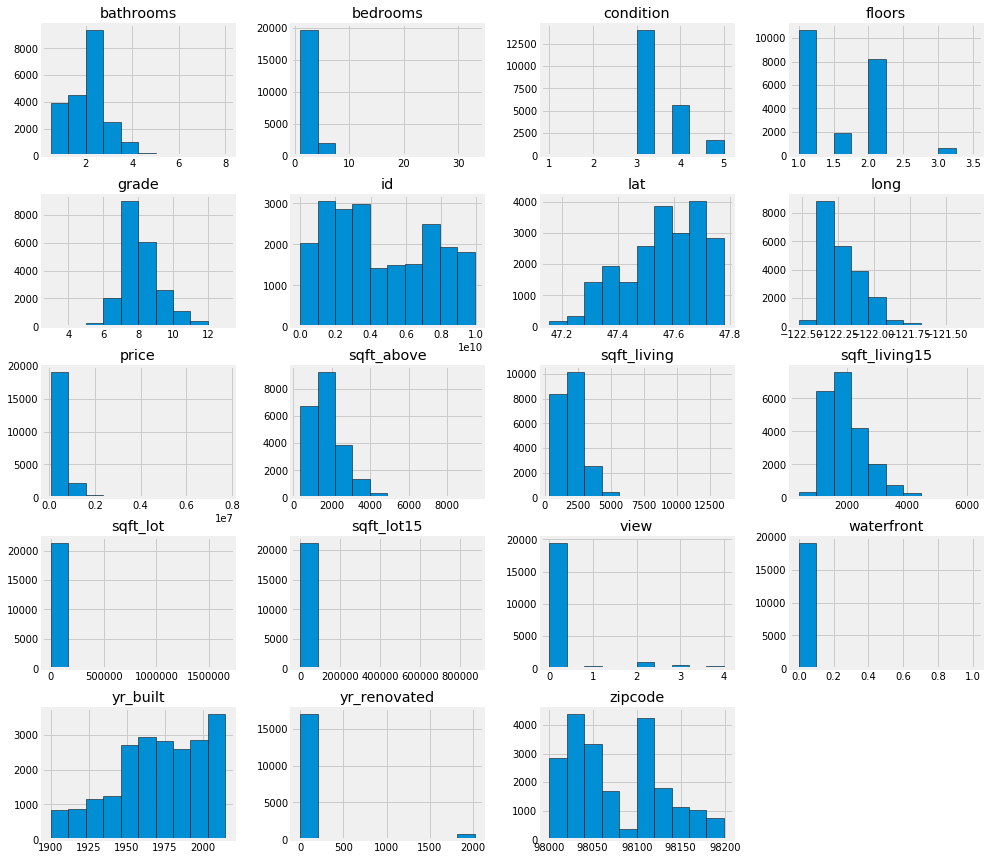

In [4]:
#distribution visualization
df.hist(figsize=(15,15), edgecolor = 'black');

In [5]:
#inspect for any columns with null values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

**Initial data analysis:**
- 'waterfront', 'view', and 'yr_renovated' have null values
- 'yr_renovated' also has a significant amount of missing values represented with a placeholder value 0
- several variables have non-normal distributions, including target variable 'price'
- several variables are categorical variables
- variance in magnitudes of several variable values 

In [6]:
#display value count of placeholder value 
df['yr_renovated'].value_counts() 

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
2000.0       29
2005.0       29
1990.0       22
2004.0       22
2009.0       21
1989.0       20
2006.0       20
2002.0       17
1991.0       16
1998.0       16
1984.0       16
1999.0       15
2008.0       15
2010.0       15
2001.0       15
1983.0       15
2015.0       14
1985.0       14
1986.0       14
1987.0       14
1994.0       14
1992.0       13
1993.0       12
1997.0       12
1995.0       12
          ...  
1975.0        5
1964.0        5
1969.0        4
1963.0        4
1973.0        4
1981.0        4
1965.0        4
1978.0        3
1960.0        3
1958.0        3
1956.0        3
1955.0        3
1945.0        3
1972.0        3
1967.0        2
1957.0        2
1940.0        2
1974.0        2
1962.0        2
1953.0        1
1950.0        1
1934.0        1
1944.0        1
1976.0        1
1948.0        1
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Leng

In [7]:
#display percentage of column with null values
waterfront_perc_missing = round((df['waterfront'].isna().sum()/len(df['waterfront']))*100, 2)
view_perc_missing = round((df['view'].isna().sum()/len(df.view))*100, 2)
yr_renovated_perc_missing = round((df['yr_renovated'].isna().sum()/len(df['yr_renovated']))*100, 2)
yr_renovated_totalperc_missing = round(((df['yr_renovated'].isna().sum()+17011)/
                                        len(df['yr_renovated']))*100, 2)

print(f"'waterfront' null percentage: {waterfront_perc_missing}")
print(f"'view' null percentage: {view_perc_missing}")
print(f"'yr_renovated' null percentage: {yr_renovated_perc_missing}")
print(f"'yr_renovated' null + placeholder values: {yr_renovated_totalperc_missing}")

'waterfront' null percentage: 11.0
'view' null percentage: 0.29
'yr_renovated' null percentage: 17.79
'yr_renovated' null + placeholder values: 96.56


---

## Data Preparation

1. Drop 'yr_renovated' column because 96.56% of its data is missing.
2. Replace null values in 'waterfront' with the most common value since the value counts are significantly different.
3. Drop rows with missing values for 'view' column since it is only 0.29% of the dataset.
4. Conduct further data analysis.

In [8]:
df = df.drop('yr_renovated', axis=1)

# replace null values in "waterfront" with most common value 0
df['waterfront'] = df['waterfront'].fillna(0)

# drop null values in 'view' column
df = df.dropna(subset=['view'])

In [9]:
#sanity check
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 20 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_above       21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
zipcode          21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
dtypes: float64(7), int64(11), object(2)
memory usage: 3.5+ MB


---

**Further data inspection**

In [11]:
#after further inspection, I've discovered another placeholder value '?'
df['sqft_basement'].value_counts().head()

0.0      12798
?          452
600.0      216
500.0      209
700.0      207
Name: sqft_basement, dtype: int64

In [12]:
#replace '?' values with difference in sqft_living and sqft_above
df.loc[df['sqft_basement'] == '?', 'sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [13]:
#change data type to float
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: float(x))

In [14]:
#drop 'id' column because it is not a predictor
#drop 'date' for now 
df = df.drop(df[['id', 'date']], axis=1)

In [15]:
#change 'yr_built' column to 'age' of house column
df['age'] = df['yr_built'].apply(lambda x: 2019 - x)
df = df.drop(['yr_built'], axis=1)

**Transform categorical columns for use in Linear Regression model**

In [16]:
# #transform categorical column 'waterfront'
# waterfront_dummies = pd.get_dummies(df["waterfront"], 
#                                     prefix="waterfront", 
#                                     drop_first=True,
#                                    dtype=int)
# df = df.drop(["waterfront"], axis=1)
# df = pd.concat([df, waterfront_dummies], axis=1)

---

### Correlation Visualization

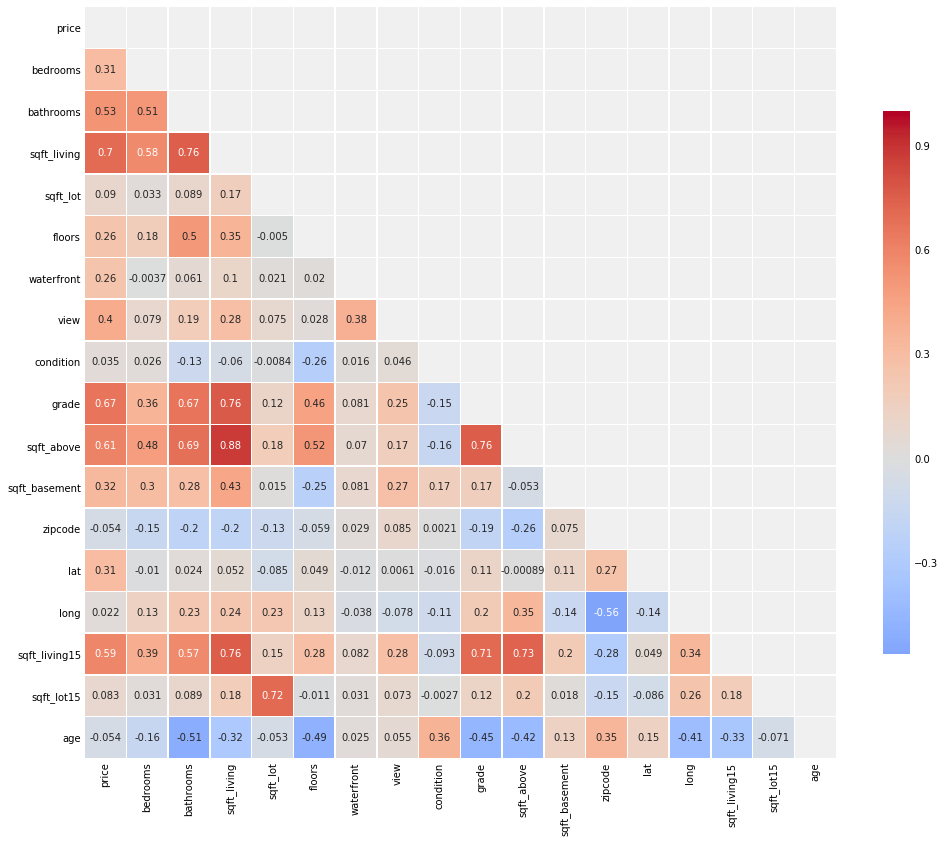

In [17]:
#visualize correlation using heatmap
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

**For my first model, I will start with variables that are positively correlated with the target variable.**

In [18]:
# create df for first model by dropping variables not positively correlated with 'price'
df_1 = df.drop(df[['zipcode', 'age']], axis=1)

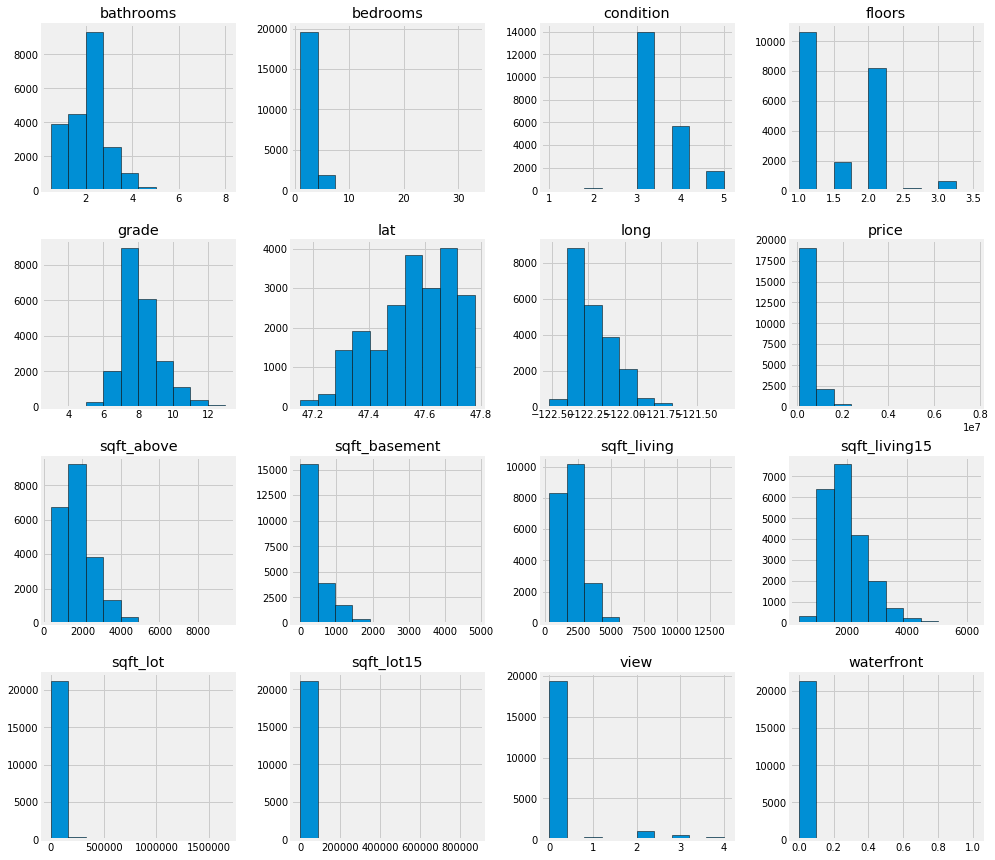

In [19]:
#let's take a look of distributions of selected predictors after preliminary data preparation
df_1.hist(figsize=(15,15), edgecolor = 'black');

---

## Linear Regression Assumption checks <br/>
1. Linearity 
2. Normality (residuals) 
3. Homoscedasticity

bedrooms
[('Jarque-Bera', 1154426.555294989), ('Prob', 0.0), ('Skew', 3.8582623896076913), ('Kurtosis', 38.02974136062947)]
Redisuals MIN: -3506465.56
Redisuals MAX: 6840169.54


<Figure size 432x288 with 0 Axes>

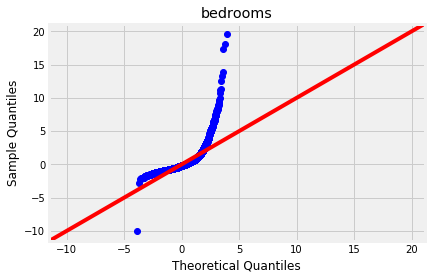

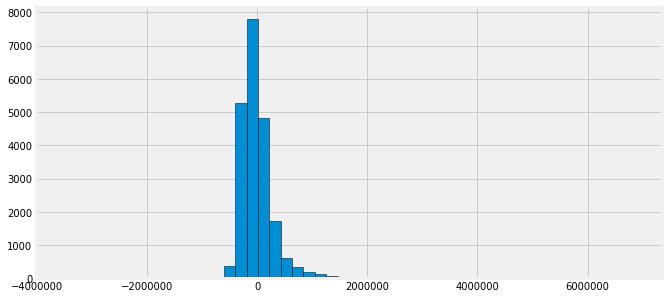

bathrooms
[('Jarque-Bera', 857836.5578051317), ('Prob', 0.0), ('Skew', 3.4214714269944073), ('Kurtosis', 33.15372611067674)]
Redisuals MIN: -1436480.23
Redisuals MAX: 5923715.15


<Figure size 432x288 with 0 Axes>

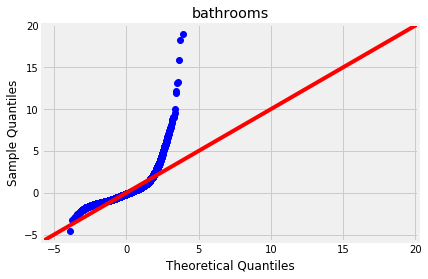

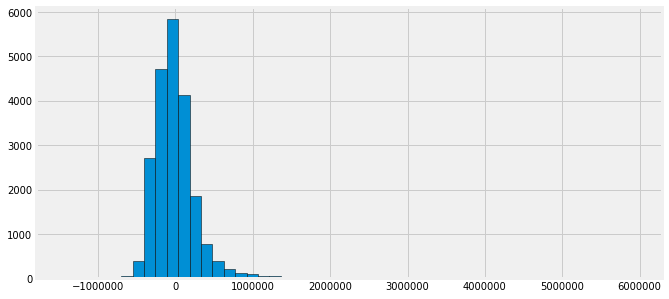

sqft_living
[('Jarque-Bera', 516142.2885372242), ('Prob', 0.0), ('Skew', 2.7805452866970697), ('Kurtosis', 26.330739573364625)]
Redisuals MIN: -1468127.9
Redisuals MAX: 4368970.96


<Figure size 432x288 with 0 Axes>

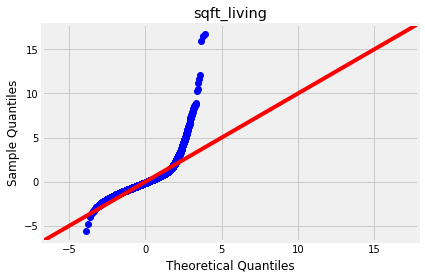

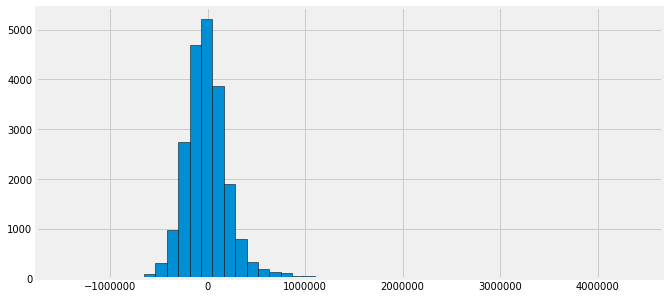

sqft_lot
[('Jarque-Bera', 1100648.8107874435), ('Prob', 0.0), ('Skew', 3.980227256085205), ('Kurtosis', 37.10751399055717)]
Redisuals MIN: -1268845.38
Redisuals MAX: 7149945.42


<Figure size 432x288 with 0 Axes>

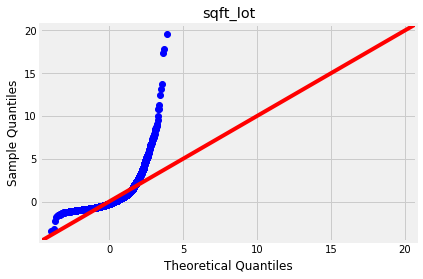

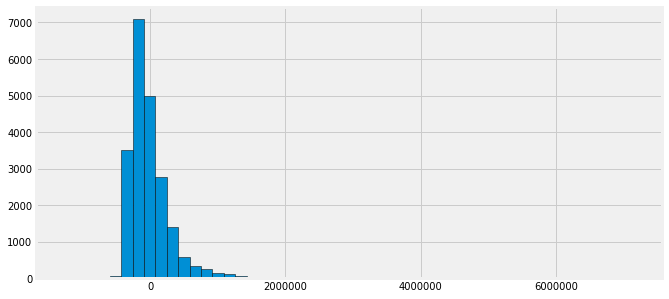

floors
[('Jarque-Bera', 1204740.126098323), ('Prob', 0.0), ('Skew', 4.025791667062309), ('Kurtosis', 38.747375414917116)]
Redisuals MIN: -597554.53
Redisuals MAX: 6984603.09


<Figure size 432x288 with 0 Axes>

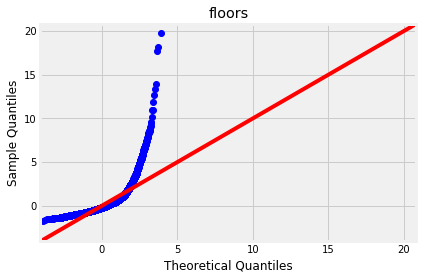

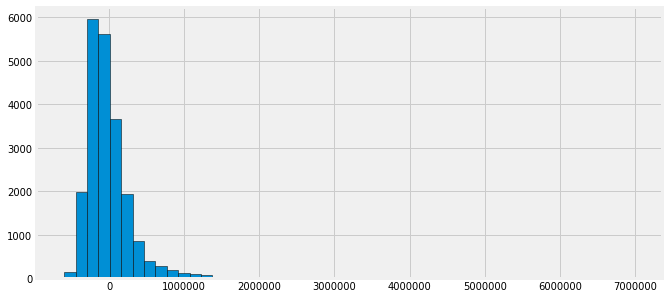

waterfront
[('Jarque-Bera', 905012.3579128587), ('Prob', 0.0), ('Skew', 3.5956892320797853), ('Kurtosis', 33.934371698271846)]
Redisuals MIN: -1407505.86
Redisuals MAX: 7167755.0


<Figure size 432x288 with 0 Axes>

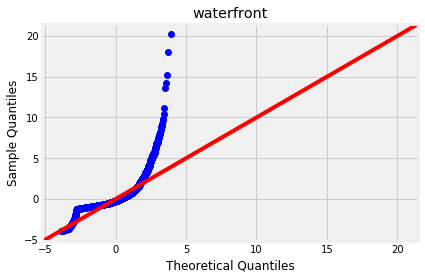

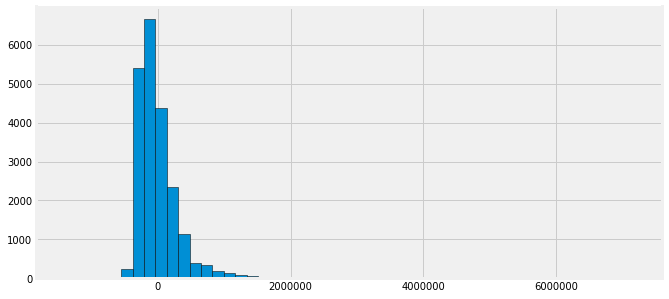

view
[('Jarque-Bera', 1003766.4420889696), ('Prob', 0.0), ('Skew', 3.5912519193098302), ('Kurtosis', 35.666894238543506)]
Redisuals MIN: -1000582.78
Redisuals MAX: 6636609.77


<Figure size 432x288 with 0 Axes>

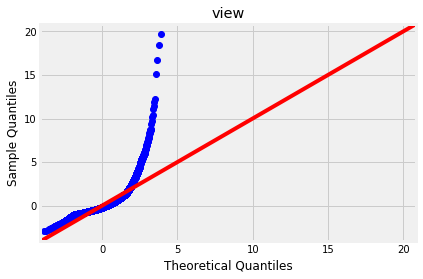

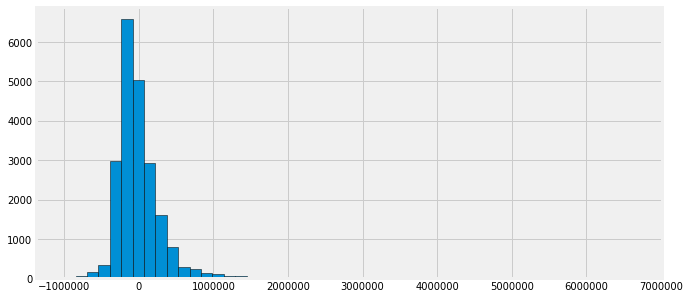

condition
[('Jarque-Bera', 1090709.5200926769), ('Prob', 0.0), ('Skew', 3.976475082304317), ('Kurtosis', 36.94649357560285)]
Redisuals MIN: -462811.35
Redisuals MAX: 7148188.65


<Figure size 432x288 with 0 Axes>

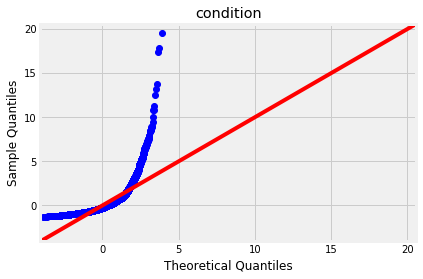

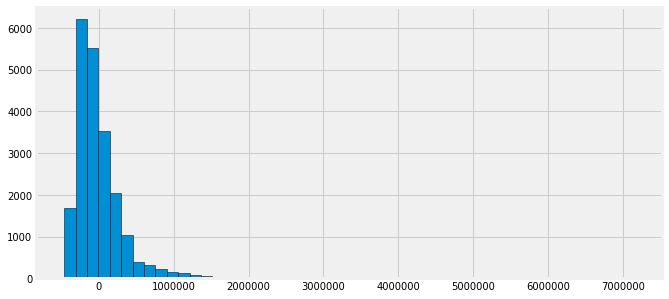

grade
[('Jarque-Bera', 1970129.654682018), ('Prob', 0.0), ('Skew', 4.0217372633227315), ('Kurtosis', 49.16323948064056)]
Redisuals MIN: -817395.74
Redisuals MAX: 6045358.17


<Figure size 432x288 with 0 Axes>

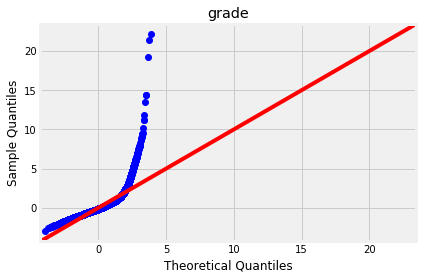

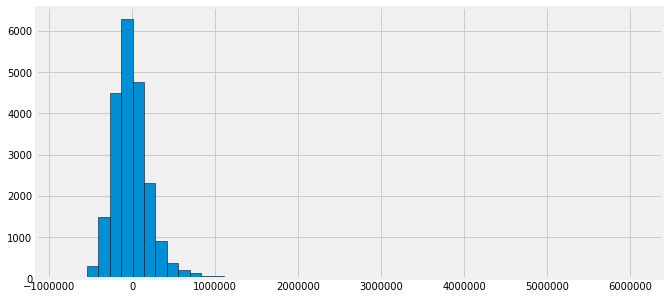

sqft_above
[('Jarque-Bera', 685308.2436162458), ('Prob', 0.0), ('Skew', 3.2120260867558423), ('Kurtosis', 29.87971265694378)]
Redisuals MIN: -910814.43
Redisuals MAX: 5343459.99


<Figure size 432x288 with 0 Axes>

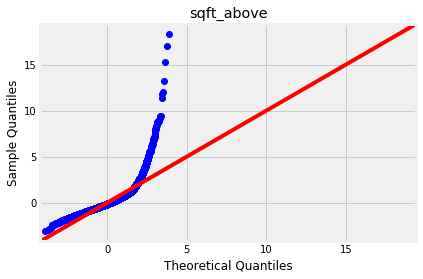

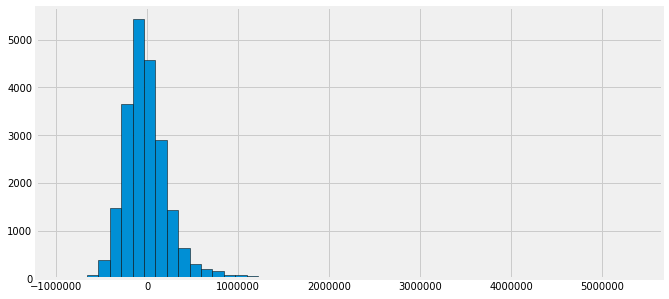

sqft_basement
[('Jarque-Bera', 862520.9799034009), ('Prob', 0.0), ('Skew', 3.662561182252118), ('Kurtosis', 33.12700638454822)]
Redisuals MIN: -599262.83
Redisuals MAX: 6310450.84


<Figure size 432x288 with 0 Axes>

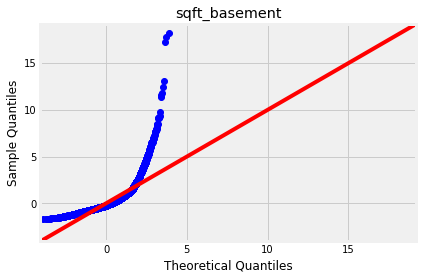

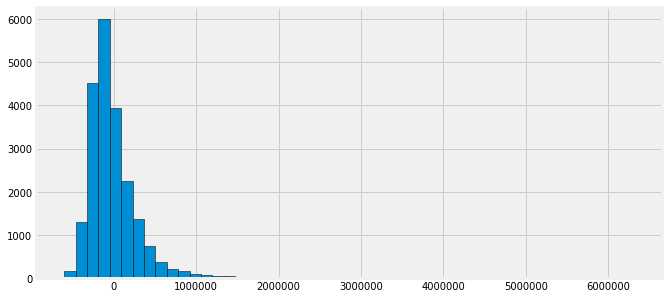

lat
[('Jarque-Bera', 1448276.0977329141), ('Prob', 0.0), ('Skew', 4.311189020834662), ('Kurtosis', 42.24006011692289)]
Redisuals MIN: -592362.2
Redisuals MAX: 7103303.49


<Figure size 432x288 with 0 Axes>

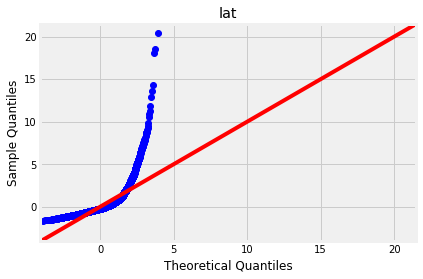

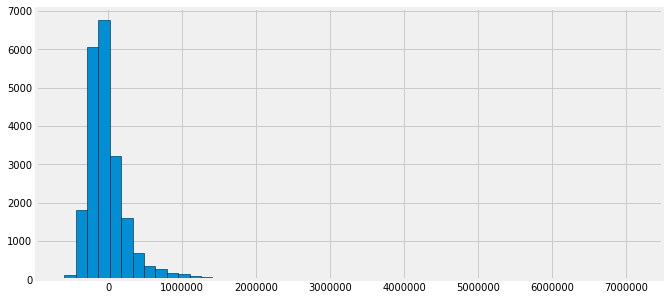

long
[('Jarque-Bera', 1091279.7026092964), ('Prob', 0.0), ('Skew', 3.983358920169944), ('Kurtosis', 36.95262474565273)]
Redisuals MIN: -477838.39
Redisuals MAX: 7166300.84


<Figure size 432x288 with 0 Axes>

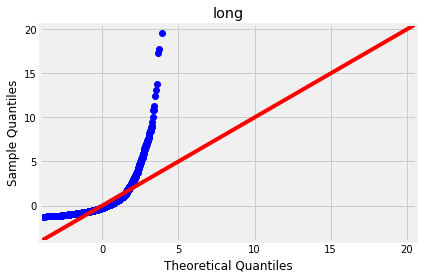

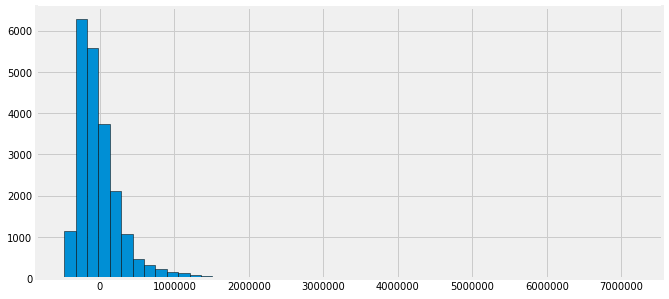

sqft_living15
[('Jarque-Bera', 1851998.0343238688), ('Prob', 0.0), ('Skew', 4.158335538283399), ('Kurtosis', 47.66447687688195)]
Redisuals MIN: -841003.88
Redisuals MAX: 6548967.03


<Figure size 432x288 with 0 Axes>

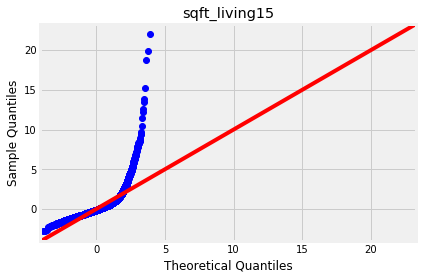

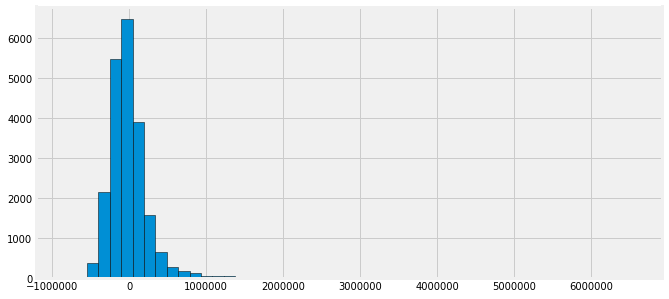

sqft_lot15
[('Jarque-Bera', 1095785.8109524415), ('Prob', 0.0), ('Skew', 3.977550644108034), ('Kurtosis', 37.0292200353399)]
Redisuals MIN: -783833.78
Redisuals MAX: 7164356.84


<Figure size 432x288 with 0 Axes>

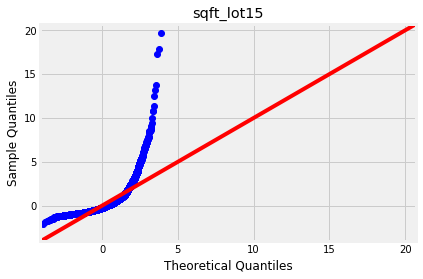

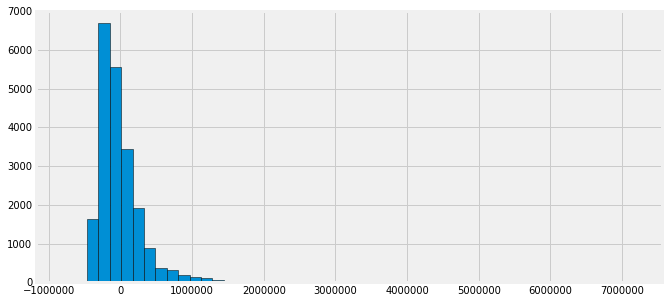

In [20]:
#Conduct normality check
normality_check(df_1)

**Observations:**
1. Based off the qq-plots and histograms, the residuals for all independent variables do not have normal distributions.
2. QQ-plots display an obvious positive skew for all independent variables and can be confirmed with its corresponding histograms.
3. Residuals max is much higher then residuals min.
4. Jarque-Bera score is incredibly high for all independent variables, indicating a non-normal distribution.
5. Skew measure is high indicating positive skewness.
5. Kurtosis for all independent variables are also high, indicating heavy tails.

**Notes**
- Jarque-Bera score roughly above 5 indicates residuals are not-normally distributed.
- Skewness lower than -1 or higher than 1 indicates high skewness.
- Kurtosis higher than 3 indicates heavier tails than a normal distribution.

**I will conduct a log-transformation on target variable 'price' and check normality of residuals**

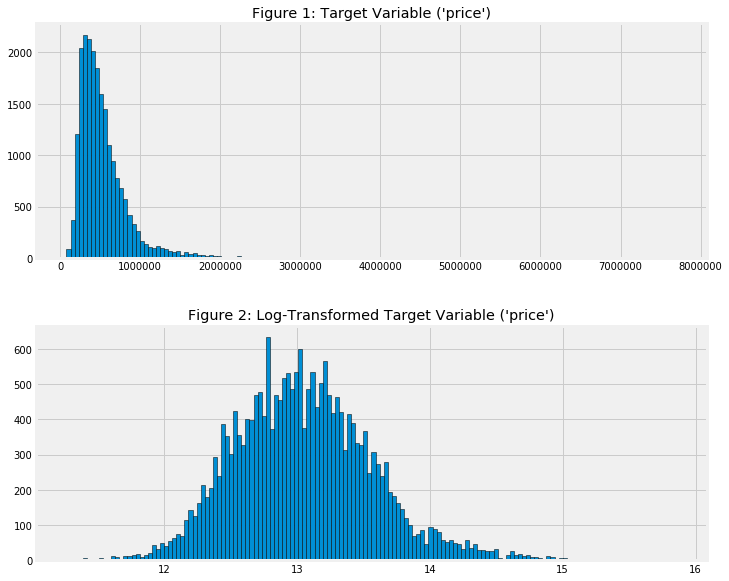

In [21]:
X_log = np.log(df_1['price'])
X = df_1['price']

fig, ax = plt.subplots(2, 1, figsize=(10,8))
fig.tight_layout(h_pad=5)
grid = plt.GridSpec(2, 1, hspace=10)

ax[0].hist(X, bins=150, edgecolor = 'black')
ax[0].set_title("Figure 1: Target Variable ('price')")
ax[1].hist(X_log, bins=150, edgecolor = 'black')
ax[1].set_title("Figure 2: Log-Transformed Target Variable ('price')")
plt.show()

bedrooms
[('Jarque-Bera', 1453.2305810130351), ('Prob', 0.0), ('Skew', 0.2895224161980989), ('Kurtosis', 4.133294602873283)]
Redisuals MIN: -5.45
Redisuals MAX: 2.41


<Figure size 432x288 with 0 Axes>

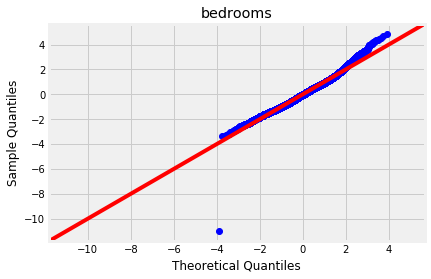

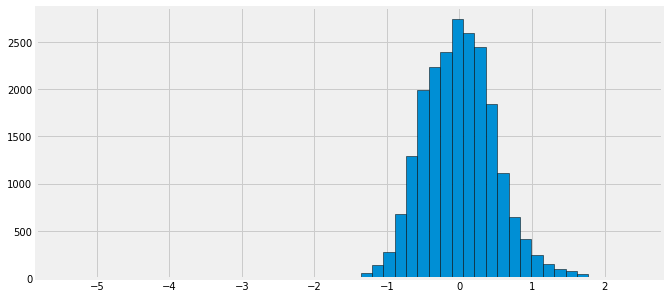

bathrooms
[('Jarque-Bera', 198.31571367687943), ('Prob', 8.635548700008987e-44), ('Skew', 0.23267251086321222), ('Kurtosis', 3.066934007883188)]
Redisuals MIN: -2.06
Redisuals MAX: 2.09


<Figure size 432x288 with 0 Axes>

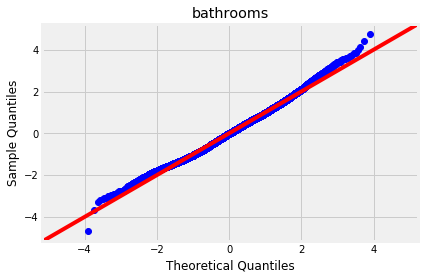

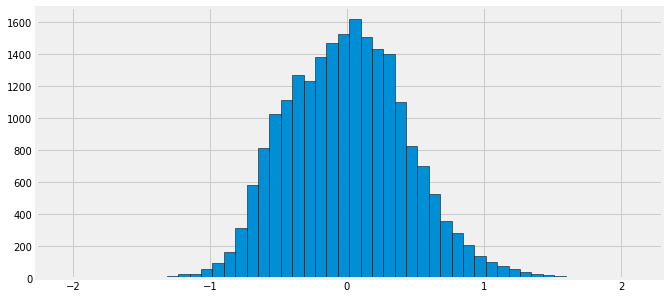

sqft_living
[('Jarque-Bera', 3.6902758157188464), ('Prob', 0.15800352945854856), ('Skew', 0.029200586074116436), ('Kurtosis', 2.9735013836714903)]
Redisuals MIN: -2.98
Redisuals MAX: 1.28


<Figure size 432x288 with 0 Axes>

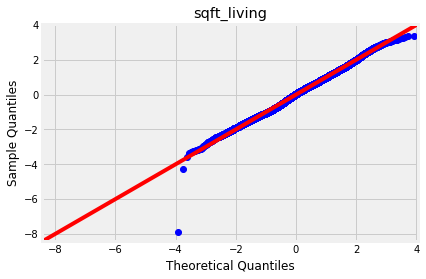

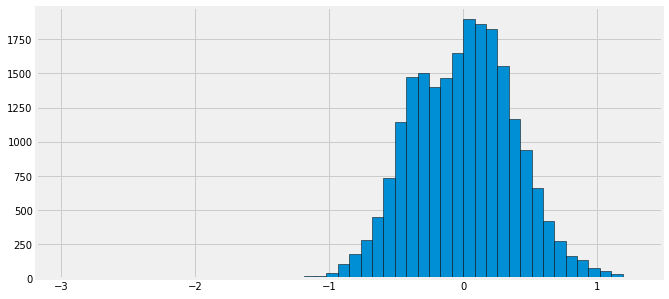

sqft_lot
[('Jarque-Bera', 1080.7913482180995), ('Prob', 2.0377020860479333e-235), ('Skew', 0.42224043729281535), ('Kurtosis', 3.701007794447613)]
Redisuals MIN: -2.36
Redisuals MAX: 2.79


<Figure size 432x288 with 0 Axes>

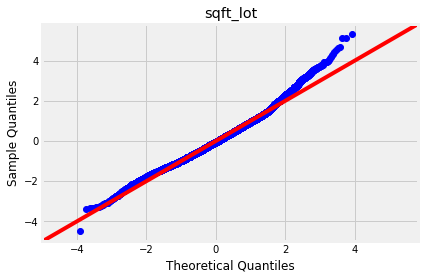

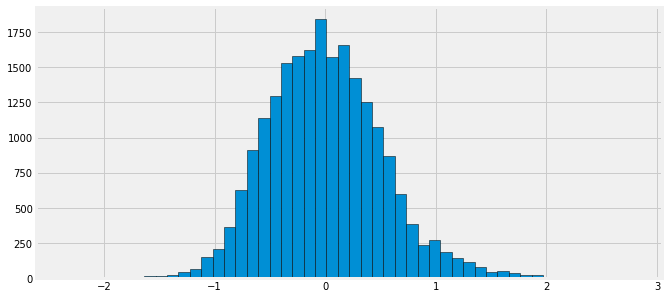

floors
[('Jarque-Bera', 1009.6642048716487), ('Prob', 5.678107683240074e-220), ('Skew', 0.43444103960770053), ('Kurtosis', 3.6085486236935074)]
Redisuals MIN: -1.79
Redisuals MAX: 2.57


<Figure size 432x288 with 0 Axes>

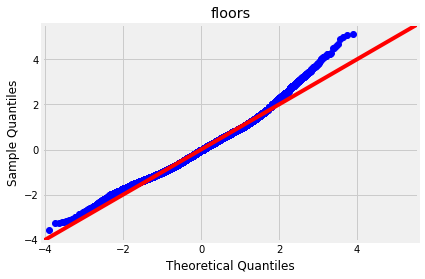

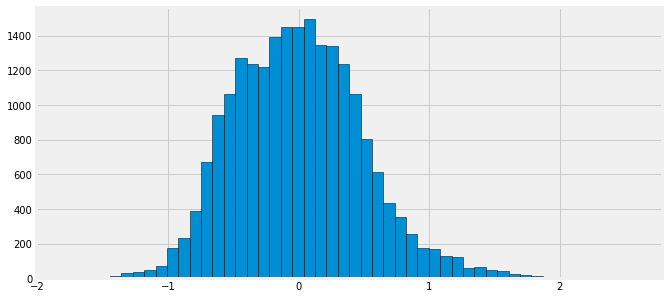

waterfront
[('Jarque-Bera', 701.9681659498474), ('Prob', 3.7115005403566824e-153), ('Skew', 0.3566532956159612), ('Kurtosis', 3.523018991423048)]
Redisuals MIN: -1.78
Redisuals MAX: 2.82


<Figure size 432x288 with 0 Axes>

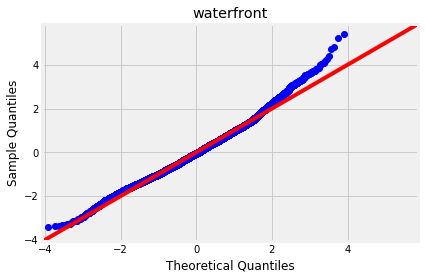

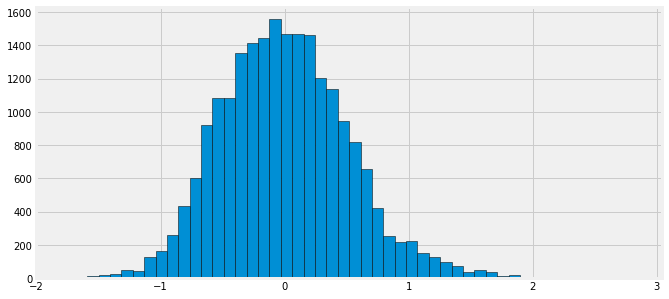

view
[('Jarque-Bera', 410.48508992504134), ('Prob', 7.316363441678062e-90), ('Skew', 0.2633927236405257), ('Kurtosis', 3.4242517300546638)]
Redisuals MIN: -1.76
Redisuals MAX: 2.54


<Figure size 432x288 with 0 Axes>

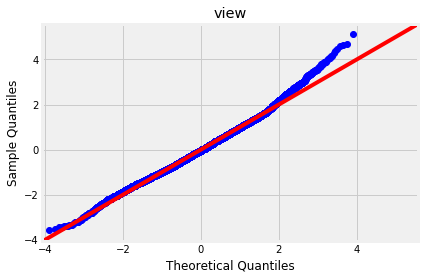

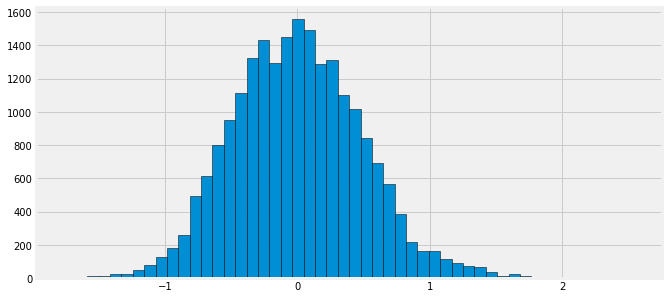

condition
[('Jarque-Bera', 1061.6172589536352), ('Prob', 2.9698962062308685e-231), ('Skew', 0.4264864827576028), ('Kurtosis', 3.6750015964098113)]
Redisuals MIN: -1.72
Redisuals MAX: 2.79


<Figure size 432x288 with 0 Axes>

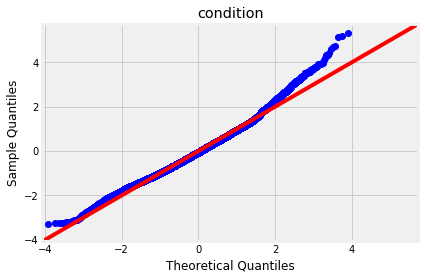

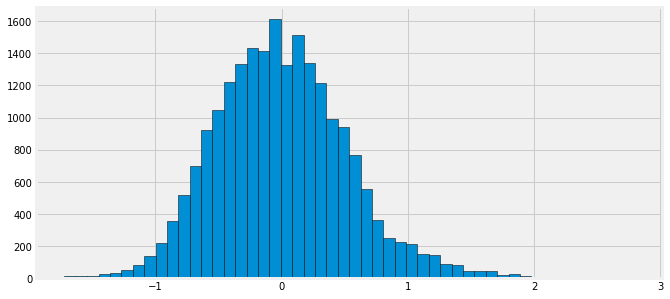

grade
[('Jarque-Bera', 133.75350522975128), ('Prob', 9.032237979159597e-30), ('Skew', 0.18161770213487027), ('Kurtosis', 3.130883689156551)]
Redisuals MIN: -1.43
Redisuals MAX: 1.78


<Figure size 432x288 with 0 Axes>

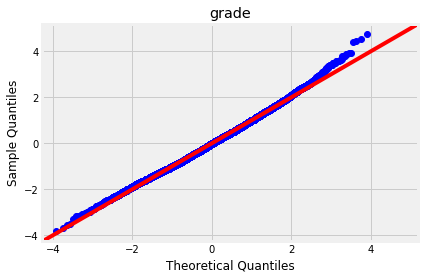

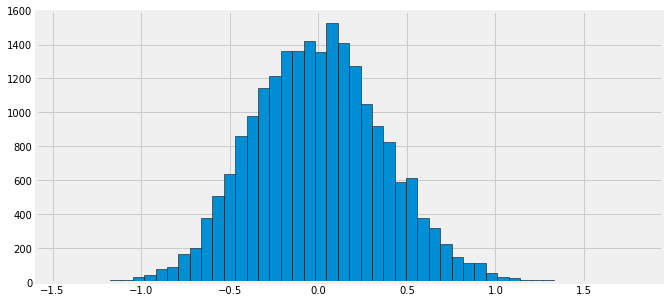

sqft_above
[('Jarque-Bera', 127.49886060941822), ('Prob', 2.0605074741217353e-28), ('Skew', 0.18585723045908747), ('Kurtosis', 2.9373266131043954)]
Redisuals MIN: -1.4
Redisuals MAX: 1.81


<Figure size 432x288 with 0 Axes>

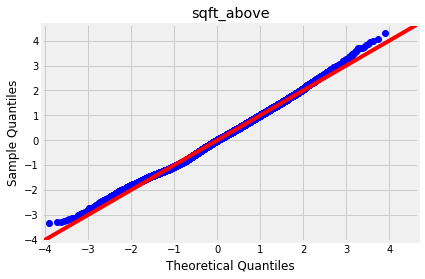

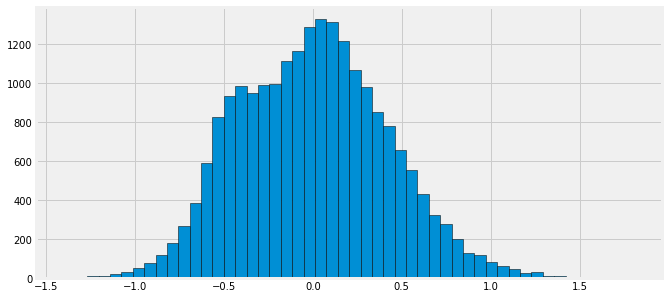

sqft_basement
[('Jarque-Bera', 692.2078564936772), ('Prob', 4.886228779733015e-151), ('Skew', 0.37818265577452237), ('Kurtosis', 3.446529559234162)]
Redisuals MIN: -1.67
Redisuals MAX: 2.42


<Figure size 432x288 with 0 Axes>

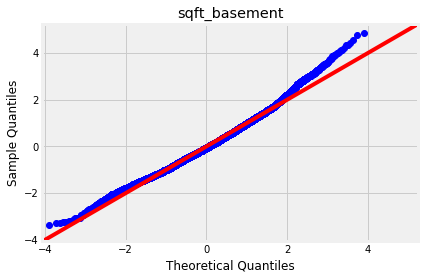

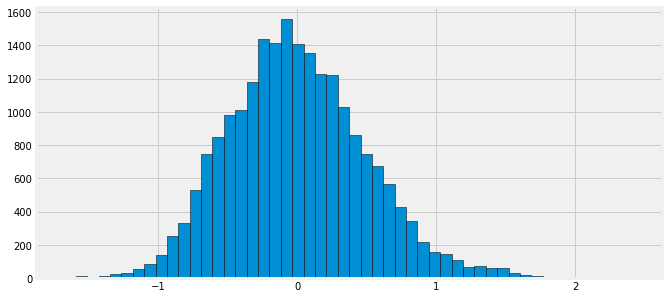

lat
[('Jarque-Bera', 2692.0661776872576), ('Prob', 0.0), ('Skew', 0.5979050600615046), ('Kurtosis', 4.2531522421021215)]
Redisuals MIN: -1.94
Redisuals MAX: 2.69


<Figure size 432x288 with 0 Axes>

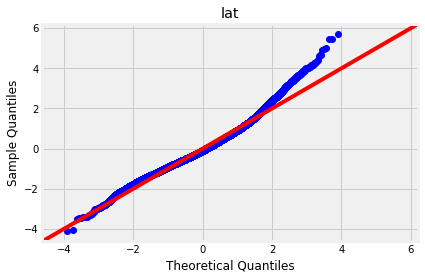

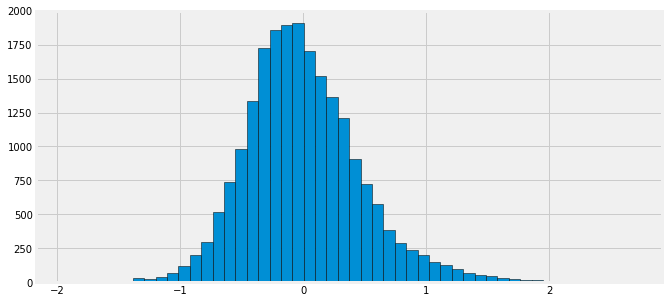

long
[('Jarque-Bera', 1137.4048856151403), ('Prob', 1.036733766503538e-247), ('Skew', 0.4389533352569681), ('Kurtosis', 3.7049372165499244)]
Redisuals MIN: -1.82
Redisuals MAX: 2.83


<Figure size 432x288 with 0 Axes>

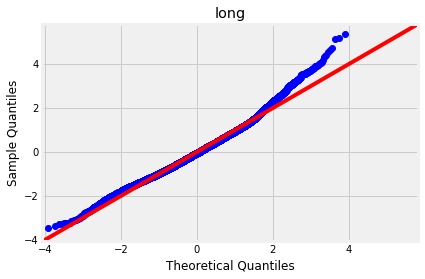

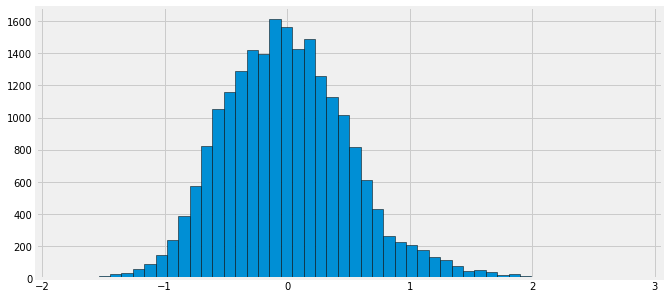

sqft_living15
[('Jarque-Bera', 450.95611239781636), ('Prob', 1.1915832851285467e-98), ('Skew', 0.28616315238965817), ('Kurtosis', 3.4183786135442547)]
Redisuals MIN: -1.89
Redisuals MAX: 1.95


<Figure size 432x288 with 0 Axes>

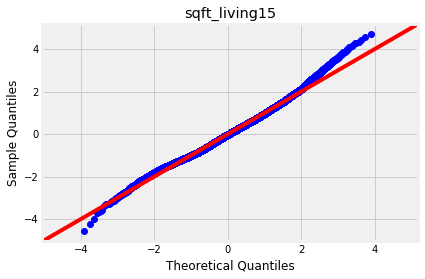

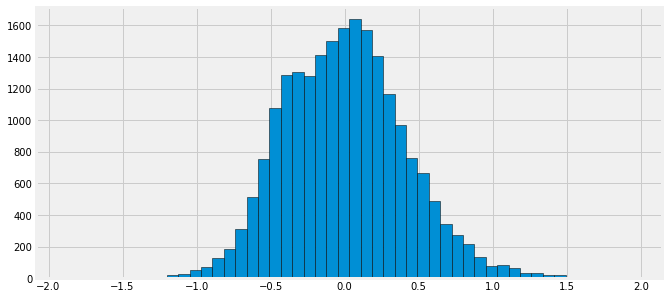

sqft_lot15
[('Jarque-Bera', 1060.978592042642), ('Prob', 4.0872013130914044e-231), ('Skew', 0.4239161690531834), ('Kurtosis', 3.680924780468658)]
Redisuals MIN: -1.81
Redisuals MAX: 2.82


<Figure size 432x288 with 0 Axes>

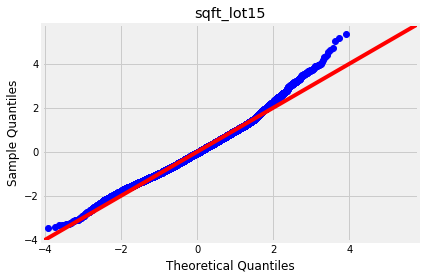

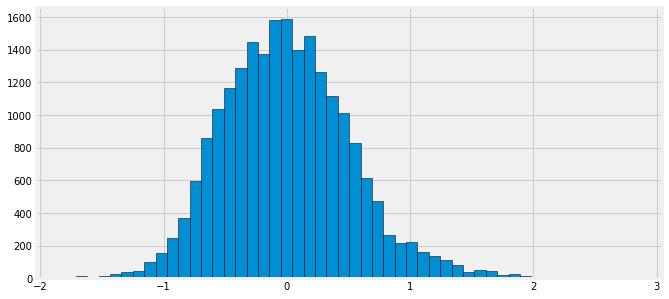

In [22]:
# Normality check using log transformation of target variable 'price'
#Create df with log-transformed 'price'
df_2 = df_1.drop(['price'], axis=1)
df_2['price'] = np.log(df['price'])

#conduct normality check
normality_check(df_2)

**Observations:**
1. By log-transforming the target variable 'price, Jarque-Bera, Skew, and Kurtosis have all gone down significantly.

In [23]:
# #plotting selected variables
# for col in df_1.drop('price', axis=1):
#     sns.jointplot(col,'price',data=df,kind='reg')
#     plt.show()

---

## Initial Multiple Linear Regression Model

**Initial model with all variables positively correlated with target ('price')**

In [24]:
#sklearn linear regression
linreg_summary(df_2)

R^2: 0.7524228686194934
MSE: 0.06901926214200708
RMSE: 0.2627151730334719
MAE: 0.2047078254178526
TRAIN_MSE: 0.06963892856230688


**Not a big difference between test MSE and TRAIN MSE which is good.** <br/>
**A big difference is an indication overfitting.**

CV 5-Fold MSE: 0.0697860902649145
CV 10-Fold MSE: 0.06976495200040671
CV 20-Fold MSE: 0.06968201281954986


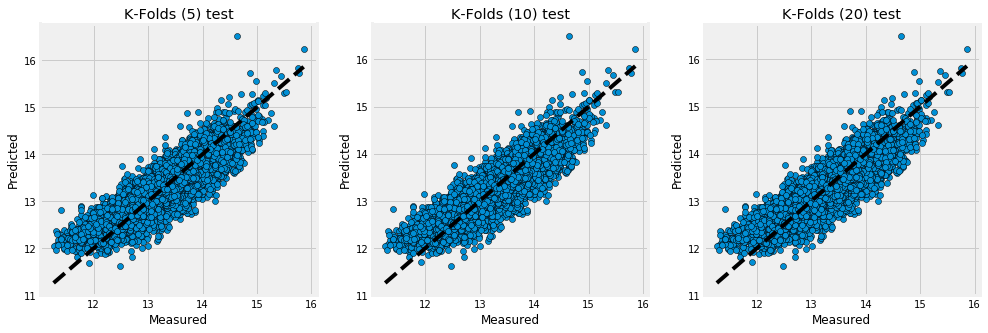

In [25]:
#conduct k-folds cross validation and a visualization of obtained predictions 
k_folds_cv(df_2)

In [26]:
#statsmodels OLS version to see p_values and adjusted R^2
ols_linreg_summary(df_2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     4589.
Date:                Fri, 13 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:33:32   Log-Likelihood:                -1846.1
No. Observations:               21534   AIC:                             3722.
Df Residuals:                   21519   BIC:                             3842.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -88.2240      1.848    -47.730      0.000     -91.847     -84.601
bedrooms         -0.0060      0.002     -2.431      0.015      -0.011      -0.001
bathrooms         0.0242      0.004      5.982      0.000       0.016       0.032
sqft_living       0.0001   2.94e-06     38.540      0.000       0.000       0.000
sqft_lot       5.593e-07   6.28e-08      8.908      0.000    4.36e-07    6.82e-07
floors            0.0338      0.005      7.339      0.000       0.025       0.043
waterfront        0.3909      0.024     16.397      0.000       0.344       0.438
view              0.0711      0.003     25.777      0.000       0.066       0.076
condition         0.0963      0.003     33.137      0.000       0.091       0.102
grade             0.1369      0.003     49.680      0.000       0.132       0.142
sqft_above     5.126e-05   2.94e-06     17.413      0.000    4.55e-05     5.7e-05
sqft_basement  6.212e-05   3.47e-06     17.918      0.000    5.53e-05    6.89e-05
lat               1.4617      0.013    108.970      0.000       1.435       1.488
long             -0.2432      0.015    -16.461      0.000      -0.272      -0.214
sqft_living15     0.0001    4.5e-06     22.798      0.000    9.38e-05       0.000
sqft_lot15    -3.054e-07   9.61e-08     -3.176      0.001   -4.94e-07   -1.17e-07
==============================================================================
Omnibus:                      314.726   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              528.955
Skew:                           0.118   Prob(JB):                    1.38e-115
Kurtosis:                       3.730   Cond. No.                     3.40e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.75e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

---

**Next model:**
1. Remove independent variables with p-value above of 0.05 
2. Remove independent variables that are highly correlated with each other

---

## Multicollinearity Check

**Correlation with an absolute value around 0.7-0.8 or higher is considered a high correlation. <br/>
I will remove independant variables that are highly correlated with each other.**

In [27]:
df_2.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,price
bedrooms,1.000000,0.514368,0.577934,0.032735,0.177391,-0.003733,0.078523,0.026402,0.356095,0.479148,0.302149,-0.010415,0.132318,0.392874,0.030952,0.342790
bathrooms,0.514368,1.000000,0.755277,0.088921,0.502285,0.061115,0.186451,-0.126682,0.665312,0.686173,0.282563,0.024487,0.225025,0.569139,0.088854,0.550788
sqft_living,0.577934,0.755277,1.000000,0.173768,0.353529,0.101982,0.282532,-0.059783,0.762398,0.876553,0.433930,0.052383,0.241856,0.756208,0.184801,0.694786
sqft_lot,0.032735,0.088921,0.173768,1.000000,-0.005025,0.021465,0.075298,-0.008375,0.115122,0.184325,0.015487,-0.085143,0.230137,0.145142,0.717095,0.100142
floors,0.177391,0.502285,0.353529,-0.005025,1.000000,0.020357,0.028436,-0.264138,0.458694,0.523367,-0.246203,0.049419,0.125329,0.279176,-0.010850,0.310492
waterfront,-0.003733,0.061115,0.101982,0.021465,0.020357,1.000000,0.382000,0.016224,0.081195,0.069931,0.080684,-0.012282,-0.037845,0.082352,0.030605,0.169036
view,0.078523,0.186451,0.282532,0.075298,0.028436,0.382000,1.000000,0.045735,0.249727,0.166299,0.274887,0.006141,-0.077894,0.279561,0.073332,0.345466
condition,0.026402,-0.126682,-0.059783,-0.008375,-0.264138,0.016224,0.045735,1.000000,-0.147326,-0.158830,0.173279,-0.015594,-0.105475,-0.093172,-0.002702,0.038400
grade,0.356095,0.665312,0.762398,0.115122,0.458694,0.081195,0.249727,-0.147326,1.000000,0.755977,0.166673,0.113787,0.200821,0.713462,0.121435,0.703402
sqft_above,0.479148,0.686173,0.876553,0.184325,0.523367,0.069931,0.166299,-0.158830,0.755977,1.000000,-0.053268,-0.000889,0.345051,0.731543,0.195413,0.601490


In [28]:
#check to see which independant variables have corraletion greater than 0.8
abs(df_2.corr()) > 0.8

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,price
bedrooms,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
sqft_above,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False


**Independant Variables Highly Correlated with each other** <br/>
sqft_living - sqft_above <br/>
sqft_above - sqft_living <br/>

**I will drop 'sqft_above' because it is highly correlated with 'sqft_living'.**

---

## Second Multiple Linear Regression Model

In [29]:
#Create new df for second model
df_3 = df_2.drop(['sqft_above'], axis=1)

In [30]:
linreg_summary(df_3)

R^2: 0.7524228686194827
MSE: 0.06901926214201005
RMSE: 0.2627151730334776
MAE: 0.2047078254178512
TRAIN_MSE: 0.06963892856230693


CV 5-Fold MSE: 0.06978609026491378
CV 10-Fold MSE: 0.06976495200040941
CV 20-Fold MSE: 0.06968201281954754


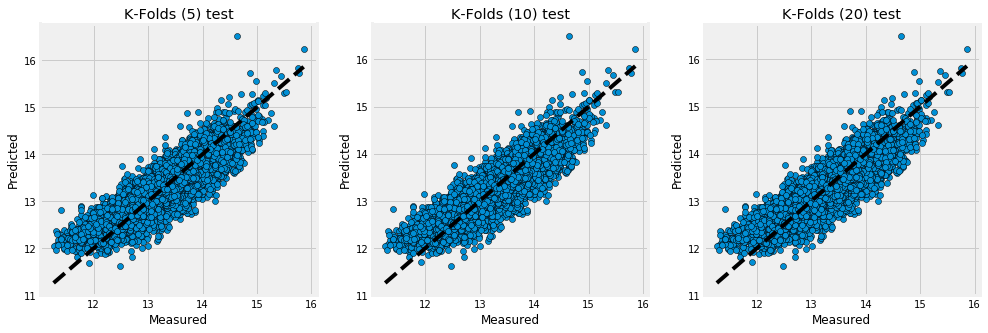

In [31]:
k_folds_cv(df_3)

In [32]:
ols_linreg_summary(df_3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     4589.
Date:                Fri, 13 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:33:35   Log-Likelihood:                -1846.1
No. Observations:               21534   AIC:                             3722.
Df Residuals:                   21519   BIC:                             3842.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -88.2240      1.848    -47.730      0.000     -91.847     -84.601
bedrooms         -0.0060      0.002     -2.431      0.015      -0.011      -0.001
bathrooms         0.0242      0.004      5.982      0.000       0.016       0.032
sqft_living       0.0002   4.76e-06     34.617      0.000       0.000       0.000
sqft_lot       5.593e-07   6.28e-08      8.908      0.000    4.36e-07    6.82e-07
floors            0.0338      0.005      7.339      0.000       0.025       0.043
waterfront        0.3909      0.024     16.397      0.000       0.344       0.438
view              0.0711      0.003     25.777      0.000       0.066       0.076
condition         0.0963      0.003     33.137      0.000       0.091       0.102
grade             0.1369      0.003     49.680      0.000       0.132       0.142
sqft_basement  1.086e-05   5.72e-06      1.899      0.058   -3.49e-07    2.21e-05
lat               1.4617      0.013    108.970      0.000       1.435       1.488
long             -0.2432      0.015    -16.461      0.000      -0.272      -0.214
sqft_living15     0.0001    4.5e-06     22.798      0.000    9.38e-05       0.000
sqft_lot15    -3.054e-07   9.61e-08     -3.176      0.001   -4.94e-07   -1.17e-07
==============================================================================
Omnibus:                      314.726   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              528.955
Skew:                           0.118   Prob(JB):                    1.38e-115
Kurtosis:                       3.730   Cond. No.                     5.20e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.2e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

**Next model:**
1. Min-max scale features due to variance of value magnitudes
2. Conduct SKLearn's Feature Ranking with Recursive Feature Elimination
3. Create dummy variables for columns with few value counts/catgorical columns?

---

In [33]:
#sqft_basement has a p-value over 0.05
df_3 = df_3.drop('sqft_basement', axis=1)

In [34]:
#conduct min-max scaling using sklearn's scaler
scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(df_3)
df_scaled = pd.DataFrame(df_scaled, columns=df_3.columns)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


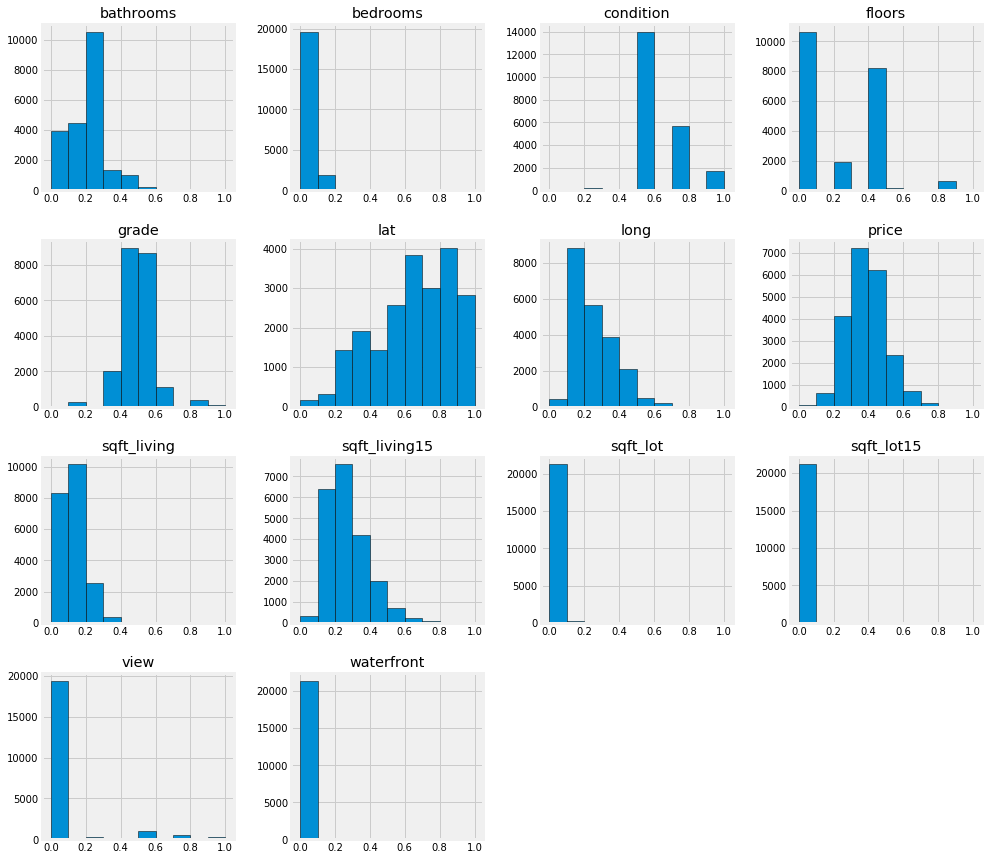

In [35]:
df_scaled.hist(figsize=(15,15), edgecolor = 'black');

In [36]:
# Feature ranking with Recursive Feature Elimination
from sklearn.feature_selection import RFE

predictors = df_scaled.drop('price', axis=1)

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 10)
selector = selector.fit(predictors, df_scaled['price'])

In [37]:
print(list(zip(predictors, selector.support_)))
print(list(zip(predictors, selector.ranking_)))

[('bedrooms', False), ('bathrooms', False), ('sqft_living', True), ('sqft_lot', True), ('floors', False), ('waterfront', True), ('view', True), ('condition', True), ('grade', True), ('lat', True), ('long', True), ('sqft_living15', True), ('sqft_lot15', True)]
[('bedrooms', 3), ('bathrooms', 2), ('sqft_living', 1), ('sqft_lot', 1), ('floors', 4), ('waterfront', 1), ('view', 1), ('condition', 1), ('grade', 1), ('lat', 1), ('long', 1), ('sqft_living15', 1), ('sqft_lot15', 1)]


In [38]:
#create a df with features from RFE
df_4 = df_scaled.drop(df_scaled[['bedrooms', 'bathrooms', 'floors']], axis=1)

In [39]:
linreg_summary(df_4)

R^2: 0.7504167872248987
MSE: 0.003299293388672579
RMSE: 0.0574394758739369
MAE: 0.044912313231187155
TRAIN_MSE: 0.0033228100128609595


In [40]:
ols_linreg_summary(df_4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     6369.
Date:                Fri, 13 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:33:38   Log-Likelihood:                 30909.
No. Observations:               21534   AIC:                        -6.180e+04
Df Residuals:                   21523   BIC:                        -6.171e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0258      0.003     -9.081      0.000      -0.031      -0.020
sqft_living       0.5157      0.010     51.655      0.000       0.496       0.535
sqft_lot          0.1932      0.023      8.545      0.000       0.149       0.238
waterfront        0.0857      0.005     16.486      0.000       0.076       0.096
view              0.0615      0.002     26.036      0.000       0.057       0.066
condition         0.0782      0.002     31.725      0.000       0.073       0.083
grade             0.3203      0.006     57.461      0.000       0.309       0.331
lat               0.1979      0.002    109.657      0.000       0.194       0.201
long             -0.0619      0.004    -16.350      0.000      -0.069      -0.054
sqft_living15     0.1209      0.006     21.526      0.000       0.110       0.132
sqft_lot15       -0.0674      0.018     -3.694      0.000      -0.103      -0.032
==============================================================================
Omnibus:                      266.971   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              446.763
Skew:                           0.088   Prob(JB):                     9.70e-98
Kurtosis:                       3.684   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

CV 5-Fold MSE: 0.003329819510486846
CV 10-Fold MSE: 0.003327404597859565
CV 20-Fold MSE: 0.003324214388279233


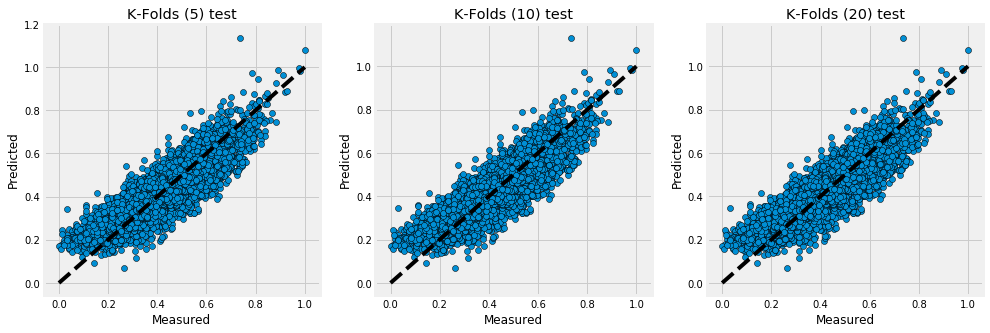

In [41]:
k_folds_cv(df_4)

**Observations:**
- Error metrics have reduced.


---

**Next Steps**
- Create map displaying locations of houses by price
- Incorporate location data using haversine to show distance to economic hub  
- Create column that incorporate distance to economic hubs 

In [42]:
wa_location_df = pd.read_csv('data/wa_zipcodes_latlong.csv', delimiter=';')
wa_location_df.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,98520,Aberdeen,WA,46.972965,-123.81923,-8,1,"46.972965,-123.81923"
1,98579,Rochester,WA,46.814438,-123.08647,-8,1,"46.814438,-123.08647"
2,98604,Battle Ground,WA,45.791345,-122.51789,-8,1,"45.791345,-122.51789"
3,98144,Seattle,WA,47.585770,-122.30081,-8,1,"47.58577,-122.30081"
4,98833,Mazama,WA,48.634796,-120.47681,-8,1,"48.634796,-120.47681"


**Visualize House Prices**

In [43]:
print(df['price'].min())
print(df['price'].max())
print(df['price'].mean())
print(df['price'].median())

78000.0
7700000.0
540057.663833937
450000.0


Text(0.5, 0, 'longitude')

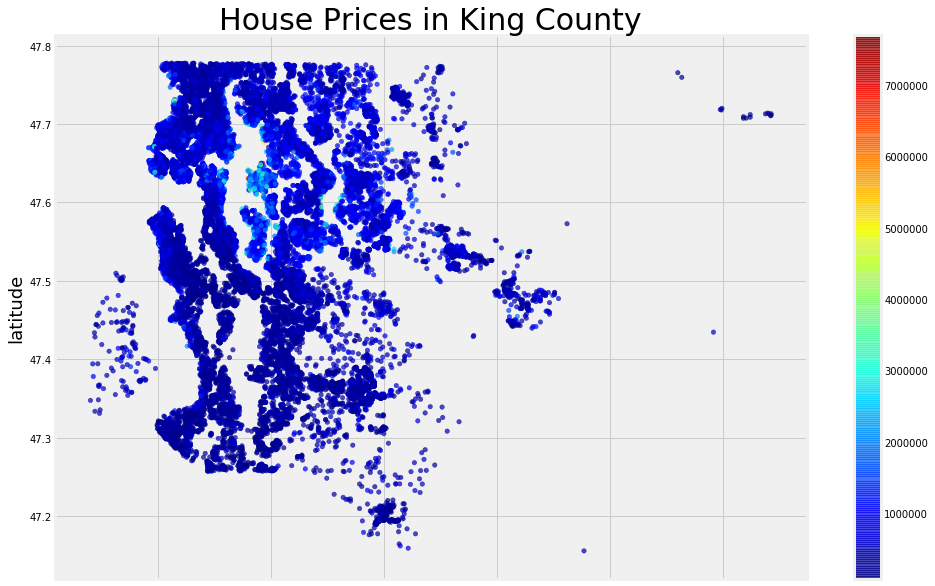

In [44]:
df.plot(kind='scatter', x='long', y='lat', 
            c=df['price'], 
            cmap=plt.get_cmap("jet"), 
            colorbar=True,
            alpha=0.7, 
            figsize=(15, 10))
plt.title('House Prices in King County', fontsize=30)
plt.ylabel('latitude',fontsize=18)
plt.xlabel('longitude', fontsize=18)

**Observations:**
- House prices appear to center around downtown Seattle.
- Because the dataset consists of houses sold between 2014 and 2015, other economic hub locations may have not been as developed quite yet.
- Creating a column that consists the distance from Seattle seems logical.

In [45]:
wa_location_df[wa_location_df['City']=='Seattle']

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
3,98144,Seattle,WA,47.585770,-122.300810,-8,1,"47.58577,-122.30081"
20,98133,Seattle,WA,47.733852,-122.344610,-8,1,"47.733852,-122.34461"
24,98174,Seattle,WA,47.604718,-122.335230,-8,1,"47.604718,-122.33523"
26,98145,Seattle,WA,47.432251,-121.803388,-8,1,"47.432251,-121.803388"
32,98105,Seattle,WA,47.663770,-122.301180,-8,1,"47.66377,-122.30118"
51,98136,Seattle,WA,47.538887,-122.388030,-8,1,"47.538887,-122.38803"
81,98104,Seattle,WA,47.602520,-122.328550,-8,1,"47.60252,-122.32855"
89,98132,Seattle,WA,47.432251,-121.803388,-8,1,"47.432251,-121.803388"
90,98122,Seattle,WA,47.611570,-122.304060,-8,1,"47.61157,-122.30406"
133,98115,Seattle,WA,47.683820,-122.301220,-8,1,"47.68382,-122.30122"


In [46]:
#how to decide what coordinates to use for seattle
#create 'distance_to_sea' column using haversine formula
#create new model